# Rejection-based EEG Signal Classification

## Import Libraries

In [2]:
import warnings

import matplotlib.pyplot as plt
import moabb
import numpy as np
import pandas as pd
import pyriemann
import seaborn as sns
from mne.decoding import CSP
from moabb.datasets import BNCI2014_001, BNCI2014_004, Cho2017
from moabb.evaluations import (CrossSessionEvaluation, CrossSubjectEvaluation,
                               WithinSessionEvaluation)
from moabb.paradigms import MotorImagery, LeftRightImagery
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
import sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

moabb.set_log_level("info")
warnings.filterwarnings("ignore")

## Instantiate a Dataset

In [4]:
dataset = BNCI2014_001()
dataset.subject_list = dataset.subject_list[:1]

datasets = [dataset]

An example of an EEG record obtained under the `mne` format, stored in a dictionary of sessions and runs.

In [51]:
sessions = dataset.get_data()

In [52]:
sessions

{1: {'0train': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>},
  '1test': {'0': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '1': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '2': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '3': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '4': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>,
   '5': <RawArray | 26 x 96735 (386.9 s), ~19.2 MB, data loaded>}}}

## Choose a Paradigm

In [83]:
print(dataset.paradigm)

imagery


In [14]:
paradigm = MotorImagery(n_classes=4)

2024-04-04 18:03:23,164 WARNING MainThread moabb.paradigms.motor_imagery Choosing from all possible events


In [15]:
paradigm.datasets

## Unpack the Dataset

The data stored in the `sklearn` format.

In [58]:
X, y, meta = paradigm.get_data(dataset=dataset)

In [59]:
print(X.shape, type(X))

(576, 22, 1001) <class 'numpy.ndarray'>


In [60]:
print(y, "\n", type(y))
print("The number of labels:", len(y))

['tongue' 'feet' 'right_hand' 'left_hand' 'left_hand' 'right_hand' 'feet'
 'tongue' 'right_hand' 'feet' 'left_hand' 'left_hand' 'left_hand' 'tongue'
 'right_hand' 'right_hand' 'left_hand' 'left_hand' 'feet' 'left_hand'
 'right_hand' 'tongue' 'tongue' 'feet' 'left_hand' 'tongue' 'tongue'
 'right_hand' 'tongue' 'tongue' 'right_hand' 'left_hand' 'right_hand'
 'feet' 'feet' 'feet' 'tongue' 'feet' 'left_hand' 'tongue' 'right_hand'
 'feet' 'right_hand' 'feet' 'tongue' 'right_hand' 'feet' 'left_hand'
 'left_hand' 'left_hand' 'tongue' 'right_hand' 'left_hand' 'feet'
 'left_hand' 'feet' 'right_hand' 'tongue' 'left_hand' 'feet' 'feet'
 'left_hand' 'feet' 'right_hand' 'tongue' 'tongue' 'tongue' 'feet'
 'left_hand' 'tongue' 'right_hand' 'tongue' 'right_hand' 'left_hand'
 'feet' 'right_hand' 'left_hand' 'feet' 'feet' 'left_hand' 'feet' 'tongue'
 'tongue' 'right_hand' 'left_hand' 'right_hand' 'tongue' 'right_hand'
 'tongue' 'feet' 'right_hand' 'right_hand' 'right_hand' 'feet' 'tongue'
 'left_hand' '

In [61]:
print(meta)

     subject session run
0          1  0train   0
1          1  0train   0
2          1  0train   0
3          1  0train   0
4          1  0train   0
..       ...     ...  ..
571        1   1test   5
572        1   1test   5
573        1   1test   5
574        1   1test   5
575        1   1test   5

[576 rows x 3 columns]


In [62]:
print(np.unique(meta["session"]))

['0train' '1test']


## Create a Pipeline

In [6]:
pipelines = {}

pipelines["RG+LR"] = make_pipeline(Covariances(), TangentSpace(), LogisticRegression(solver="lbfgs"))

## Evaluate a Solution

In [7]:
# Evaluate for a specific number of training samples per class.
data_size = dict(policy="per_class", value=np.array([5, 10, 30, 50]))
# When the training data is sparse, perform more permutations than when we have a lot of data.
n_perms = np.floor(np.geomspace(20, 2, len(data_size["value"]))).astype(int)

In [16]:
evaluation = WithinSessionEvaluation(
    paradigm=paradigm,
    datasets=datasets,
    overwrite=True,
    data_size=data_size,
    n_perms=n_perms,
)

In [17]:
results = evaluation.process(pipelines)

2024-04-04 18:03:47,588 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-WithinSession:   0%|          | 0/1 [00:00<?, ?it/s]2024-04-04 18:03:50,888 INFO MainThread moabb.evaluations.evaluations Permutation: 1, Training samples: 20
2024-04-04 18:03:50,940 INFO MainThread moabb.evaluations.base RG+LR | BNCI2014-001 | 1 | 0train: Score 0.707
2024-04-04 18:03:51,111 INFO MainThread moabb.evaluations.evaluations Permutation: 1, Training samples: 40
2024-04-04 18:03:51,183 INFO MainThread moabb.evaluations.base RG+LR | BNCI2014-001 | 1 | 0train: Score 0.759
2024-04-04 18:03:51,353 INFO MainThread moabb.evaluations.evaluations Permutation: 1, Training samples: 120
2024-04-04 18:03:51,489 INFO MainThread moabb.evaluations.base RG+LR | BNCI2014-001 | 1 | 0train: Score 0.845
2024-04-04 18:03:51,645 INFO MainThread moabb.evaluations.evaluations Permutation: 1, Training samples: 200
2024-04-04 18:03:51,866 INFO MainThread moabb.evaluations.base RG+LR | BNCI2014

In [10]:
print(results.head(n=5))

      score      time  samples  data_size  permutation subject session  \
0  0.814286  0.036052     10.0       10.0          1.0       1  0train   
1  0.876190  0.048161     20.0       20.0          1.0       1  0train   
2  0.980952  0.066610     60.0       60.0          1.0       1  0train   
3  1.000000  0.104161    100.0      100.0          1.0       1  0train   
4  0.852381  0.022987     10.0       10.0          2.0       1  0train   

   channels  n_sessions       dataset pipeline  
0        22           2  BNCI2014-001    RG+LR  
1        22           2  BNCI2014-001    RG+LR  
2        22           2  BNCI2014-001    RG+LR  
3        22           2  BNCI2014-001    RG+LR  
4        22           2  BNCI2014-001    RG+LR  


In [11]:
results.to_csv("./results.csv")

In [12]:
results = pd.read_csv("./results.csv")

## Plot the Results

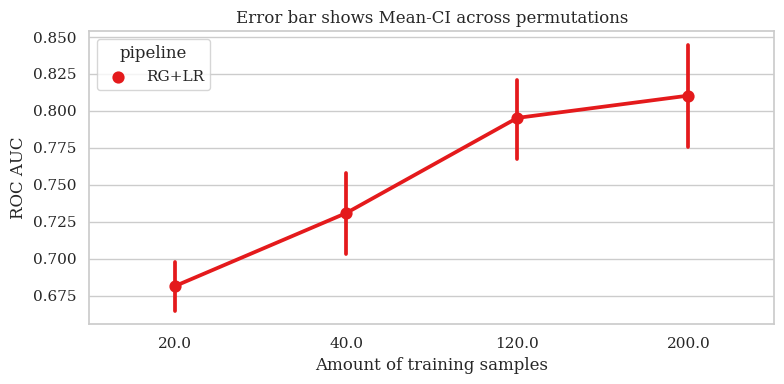

In [18]:
fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])

n_subs = len(dataset.subject_list)

if n_subs > 1:
    r = results.groupby(["pipeline", "subject", "data_size"]).mean().reset_index()
else:
    r = results

sns.pointplot(data=r, x="data_size", y="score", hue="pipeline", ax=ax, palette="Set1")

errbar_meaning = "subjects" if n_subs > 1 else "permutations"
title_str = f"Error bar shows Mean-CI across {errbar_meaning}"
ax.set_xlabel("Amount of training samples")
ax.set_ylabel("ROC AUC")
ax.set_title(title_str)
fig.tight_layout()
plt.show()

## Split the Data

In [ ]:
train_sessions = meta[meta["session"] == "0train"]
test_sessions = meta[meta["session"] == "1test"]

In [ ]:
X_train = X[train_sessions.index]
X_test = X[test_sessions.index]

y_train = labels[train_sessions.index]
y_test = labels[test_sessions.index]

## Define a Range of Sample Sizes

In [ ]:
min_sample_size = 50
max_sample_size = len(X_train)
step_size = 50

sample_sizes = np.arange(min_sample_size, max_sample_size + step_size, step_size)

## Train a Model

In [ ]:
accuracies = []
for size in sample_sizes:
    # Randomly select a subset of the training data.
    indices = np.random.choice(len(X_train), size=size, replace=False)
    X_subset = X_train[indices]
    y_subset = y_train[indices]

    # Train a logistic regression model.
    evaluation = WithinSessionEvaluation(paradigm=paradigm,
                                         datasets=[dataset],
                                         overwrite=True,
                                         hdf5_path=None,
                                         )

    # Make predictions on the test set.
    y_pred = model.predict(X_test)

    # Calculate accuracy and store it.
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)